🔧 **Setup Required**: Before running this notebook, please follow the [setup instructions](../README.md#setup-instructions) to configure your environment and API keys.

# Building an Async Hybrid RAG Pipeline with Haystack

Welcome to this notebook where we'll build an **asynchronous** Retrieval-Augmented Generation (RAG) pipeline using Haystack's `AsyncPipeline`. This approach enables concurrent execution of components for significantly improved performance.

## What You'll Learn

- How to use `AsyncPipeline` for concurrent component execution
- Three different execution methods: `run()`, `run_async()`, and `run_async_generator()`
- The performance benefits of async execution in hybrid retrieval
- How to monitor pipeline progress with async generators
- Best practices for asynchronous pipeline design

## Why AsyncPipeline?

The `AsyncPipeline` provides significant performance improvements by:

1. **Parallel Retrieval**: Dense and sparse retrievers run concurrently
2. **Non-blocking Execution**: Better resource utilization for I/O-bound operations
3. **Incremental Output**: Monitor progress as components complete
4. **Scalability**: Handle multiple queries efficiently

### When to Use AsyncPipeline

- ✅ Hybrid retrieval pipelines with multiple retrievers
- ✅ Multiple LLM calls that can run concurrently
- ✅ Complex pipelines with independent branches
- ✅ I/O-bound operations (API calls, database queries)
- ❌ Simple linear pipelines with few components
- ❌ CPU-bound operations without I/O waits

## 1. Import Required Components

We'll use the same components as the synchronous hybrid pipeline, but with `AsyncPipeline` instead of `Pipeline`.

In [ ]:
import asyncio
from haystack import AsyncPipeline, Document
from haystack.components.embedders import SentenceTransformersTextEmbedder, SentenceTransformersDocumentEmbedder
from haystack.components.retrievers.in_memory import InMemoryEmbeddingRetriever, InMemoryBM25Retriever
from haystack.components.joiners import DocumentJoiner
from haystack.components.rankers import SentenceTransformersSimilarityRanker
from haystack.components.builders import PromptBuilder
from haystack.components.generators import OpenAIGenerator
from haystack.document_stores.in_memory import InMemoryDocumentStore
from haystack.utils import Secret

/Users/laurafunderburk/Documents/GitHub/Building-Natural-Language-Pipelines/ch4/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2. Prepare Document Store

We'll use the same indexing approach, but let's create a self-contained example with sample documents.

In [2]:
# Create sample documents about Haystack
documents = [
    Document(content="Haystack is an open-source framework for building production-ready LLM applications, retrieval-augmented generative pipelines and state-of-the-art search systems that work intelligently over large document collections."),
    Document(content="Haystack 2.0 introduced a completely redesigned architecture with improved composability, making it easier to build custom pipelines and integrate various NLP models."),
    Document(content="With Haystack, you can build applications like semantic search engines, question answering systems, document retrieval systems, and complex RAG pipelines with multiple retrievers."),
    Document(content="The Pipeline class in Haystack allows you to connect different components like retrievers, rankers, and generators to create sophisticated NLP workflows."),
    Document(content="Haystack supports various document stores including Elasticsearch, OpenSearch, Pinecone, Weaviate, and in-memory stores for development and testing."),
    Document(content="AsyncPipeline in Haystack enables concurrent execution of independent components, significantly improving performance for hybrid retrieval and parallel processing scenarios."),
    Document(content="Haystack provides both dense retrieval using embeddings and sparse retrieval using BM25, which can be combined for hybrid search with improved accuracy."),
    Document(content="The framework includes pre-built components for document preprocessing, embedding generation, retrieval, re-ranking, and answer generation using various LLM providers."),
]

# Initialize document embedder and create embeddings
print("Embedding documents...")
docs_embedder = SentenceTransformersDocumentEmbedder(model="sentence-transformers/all-MiniLM-L6-v2")
docs_embedder.warm_up()
embedded_docs = docs_embedder.run(documents=documents)["documents"]

# Create and populate document store
document_store = InMemoryDocumentStore()
document_store.write_documents(embedded_docs)

print(f"✓ Indexed {document_store.count_documents()} documents")

Embedding documents...


Batches: 100%|██████████| 1/1 [00:00<00:00,  2.43it/s]

✓ Indexed 8 documents


## 3. Initialize Pipeline Components

We'll set up the same components as the synchronous pipeline:

- **Text Embedder**: Converts queries to embeddings
- **Embedding Retriever**: Dense retrieval using semantic similarity
- **BM25 Retriever**: Sparse retrieval using keyword matching
- **Document Joiner**: Combines results from both retrievers
- **Ranker**: Re-ranks combined results for relevance
- **Prompt Builder**: Creates prompts from ranked documents
- **LLM Generator**: Generates final answers

In [3]:
# Initialize all pipeline components

# Text embedder for query
text_embedder = SentenceTransformersTextEmbedder(model="sentence-transformers/all-MiniLM-L6-v2")

# Dense retriever using embeddings
embedding_retriever = InMemoryEmbeddingRetriever(document_store=document_store, top_k=3)

# Sparse retriever using BM25
bm25_retriever = InMemoryBM25Retriever(document_store=document_store, top_k=3)

# Document joiner to combine results
document_joiner = DocumentJoiner()

# Ranker to improve relevance
ranker = SentenceTransformersSimilarityRanker(model="BAAI/bge-reranker-base", top_k=3)

# Prompt template for the LLM
prompt_template = """
You are a precise, factual QA assistant.
According to the following documents:
{% for document in documents %}
{{document.content}}
{% endfor %}

If an answer cannot be deduced from the documents, say "I don't know based on these documents".

When answering:
- Be concise and factual
- List the key information that supports your answer

Question: {{question}}
Answer:
"""

prompt_builder = PromptBuilder(template=prompt_template)

# LLM Generator
llm_generator = OpenAIGenerator(
    api_key=Secret.from_env_var("OPENAI_API_KEY"),
    model="gpt-4o-mini"
)

# Optional: Use Ollama for local inference
# from haystack_integrations.components.generators.ollama import OllamaGenerator
# llm_generator = OllamaGenerator(
#     model="mistral-nemo:12b",
#     generation_kwargs={"num_predict": 200, "temperature": 0.7}
# )

print("✓ All components initialized")

PromptBuilder has 2 prompt variables, but `required_variables` is not set. By default, all prompt variables are treated as optional, which may lead to unintended behavior in multi-branch pipelines. To avoid unexpected execution, ensure that variables intended to be required are explicitly set in `required_variables`.


✓ All components initialized


## 4. Build the AsyncPipeline

Now we'll create an `AsyncPipeline` instead of a regular `Pipeline`. The component connections are identical, but execution will be asynchronous.

### Pipeline Flow

1. **Parallel Retrieval**: Both retrievers run concurrently
   - Text embedder → Embedding retriever (dense)
   - BM25 retriever (sparse)

2. **Result Combination**: Documents are joined

3. **Re-ranking**: Combined results are re-ranked

4. **Answer Generation**: Prompt is built and sent to LLM

In [4]:
# Create AsyncPipeline
async_hybrid_rag = AsyncPipeline()

# Add components
async_hybrid_rag.add_component("text_embedder", text_embedder)
async_hybrid_rag.add_component("embedding_retriever", embedding_retriever)
async_hybrid_rag.add_component("bm25_retriever", bm25_retriever)
async_hybrid_rag.add_component("document_joiner", document_joiner)
async_hybrid_rag.add_component("ranker", ranker)
async_hybrid_rag.add_component("prompt_builder", prompt_builder)
async_hybrid_rag.add_component("llm", llm_generator)

# Connect components
async_hybrid_rag.connect("text_embedder.embedding", "embedding_retriever.query_embedding")
async_hybrid_rag.connect("embedding_retriever.documents", "document_joiner.documents")
async_hybrid_rag.connect("bm25_retriever.documents", "document_joiner.documents")
async_hybrid_rag.connect("document_joiner.documents", "ranker.documents")
async_hybrid_rag.connect("ranker.documents", "prompt_builder.documents")
async_hybrid_rag.connect("prompt_builder.prompt", "llm.prompt")

print("✓ AsyncPipeline built successfully")

✓ AsyncPipeline built successfully


## 5. Visualize the Pipeline

Let's visualize the async pipeline structure. Notice how components that don't depend on each other can run in parallel.

Pipeline visualization saved to: images/async_hybrid_rag_pipeline.png


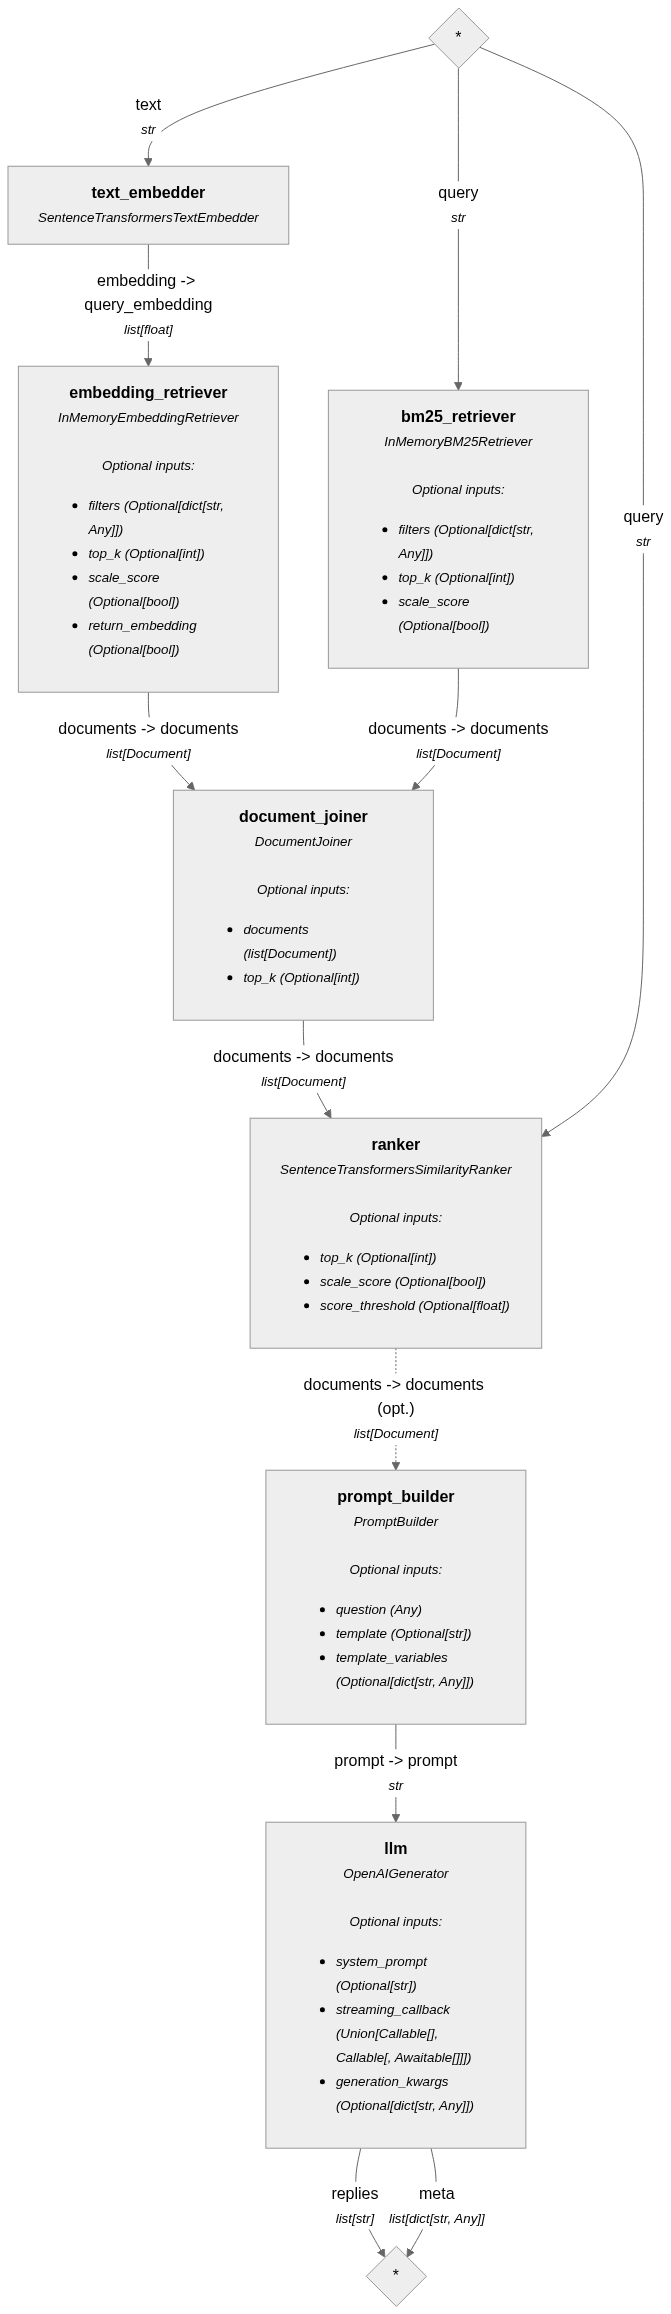

In [5]:
import os

# Draw the pipeline
image_path = os.path.join("images", "async_hybrid_rag_pipeline.png")
async_hybrid_rag.draw(path=image_path)
print(f"Pipeline visualization saved to: {image_path}")

# Display the image
try:
    from IPython.display import Image, display
    display(Image(image_path))
except Exception as e:
    print(f"Could not display image: {e}")

## 6. Execution Method 1: Synchronous Run

The `run()` method executes the pipeline synchronously, blocking until completion. While components execute concurrently internally, this method is useful when you need to wait for results.

**Use Case**: Simple scripts or when you need the complete result before proceeding.

In [14]:
import time

# Define a test question
question = "What is Haystack and what can you build with it?"

# Prepare input data for all starting components
data = {
    "text_embedder": {"text": question},
    "bm25_retriever": {"query": question},
    "ranker": {"query": question},
    "prompt_builder": {"question": question}
}

# Run synchronously
print("Running pipeline synchronously...\n")
start_time = time.time()

result = async_hybrid_rag.run_async(data=data)

elapsed = time.time() - start_time

# Display results
print(f"Question: {question}")
print(f"\nAnswer: {result}")
print(f"\n⏱️  Execution time: {elapsed:.2f} seconds")

Running pipeline synchronously...

Question: What is Haystack and what can you build with it?

Answer: <coroutine object AsyncPipeline.run_async at 0x3958a5b40>

⏱️  Execution time: 0.00 seconds


## 7. Execution Method 2: Asynchronous Run

The `run_async()` method executes the pipeline asynchronously in a non-blocking manner. This is ideal for integrating into async applications.

**Use Case**: Web servers, async APIs, or when handling multiple queries concurrently.

In [10]:
# Define an async function to run the pipeline
async def run_async_pipeline(question: str):
    """Run the pipeline asynchronously."""
    data = {
        "text_embedder": {"text": question},
        "bm25_retriever": {"query": question},
        "ranker": {"query": question},
        "prompt_builder": {"question": question}
    }
    
    print("Running pipeline asynchronously...\n")
    start_time = time.time()
    
    # Run asynchronously
    result = await async_hybrid_rag.run_async(data=data)
    
    elapsed = time.time() - start_time
    
    print(f"Question: {question}")
    print(f"\nAnswer: {result['llm']['replies'][0]}")
    print(f"\n⏱️  Execution time: {elapsed:.2f} seconds")
    
    return result

# Run the async function
question = "How does AsyncPipeline improve performance in Haystack?"
result = await run_async_pipeline(question)

Running pipeline asynchronously...



Batches: 100%|██████████| 1/1 [00:00<00:00, 12.52it/s]



Question: How does AsyncPipeline improve performance in Haystack?

Answer: AsyncPipeline improves performance in Haystack by enabling concurrent execution of independent components. This allows for significant enhancements in scenarios involving hybrid retrieval and parallel processing. 

Key information:
- Allows concurrent execution of components
- Improves performance for hybrid retrieval scenarios
- Enhances performance in parallel processing situations

⏱️  Execution time: 6.58 seconds


/var/folders/k7/8m84jpf52x7gvx628v82h2p80000gn/T/ipykernel_49722/2331087805.py:27: RuntimeWarning: coroutine 'AsyncPipeline.run_async' was never awaited
  result = await run_async_pipeline(question)


## 8. Execution Method 3: Async Generator (Streaming)

The `run_async_generator()` method yields partial outputs as components complete. This is perfect for:

- **Progress Monitoring**: See which components have finished
- **Debugging**: Inspect intermediate results
- **Streaming UI**: Update the interface as results arrive

**Use Case**: Interactive applications, progress bars, real-time feedback.

In [11]:
async def run_with_streaming(question: str):
    """Run the pipeline with streaming output."""
    data = {
        "text_embedder": {"text": question},
        "bm25_retriever": {"query": question},
        "ranker": {"query": question},
        "prompt_builder": {"question": question}
    }
    
    print("Running pipeline with streaming output...\n")
    print(f"Question: {question}\n")
    print("=" * 80)
    
    start_time = time.time()
    
    # Stream outputs as components complete
    # We specify which components to include in the output
    async for partial_output in async_hybrid_rag.run_async_generator(
        data=data,
        include_outputs_from={"embedding_retriever", "bm25_retriever", "document_joiner", "ranker", "llm"}
    ):
        # Check which component produced output
        if "embedding_retriever" in partial_output:
            docs = partial_output["embedding_retriever"]["documents"]
            print(f"✓ Embedding Retriever: Retrieved {len(docs)} documents (dense search)")
        
        if "bm25_retriever" in partial_output:
            docs = partial_output["bm25_retriever"]["documents"]
            print(f"✓ BM25 Retriever: Retrieved {len(docs)} documents (sparse search)")
        
        if "document_joiner" in partial_output:
            docs = partial_output["document_joiner"]["documents"]
            print(f"✓ Document Joiner: Combined {len(docs)} total documents")
        
        if "ranker" in partial_output:
            docs = partial_output["ranker"]["documents"]
            print(f"✓ Ranker: Re-ranked to top {len(docs)} most relevant documents")
        
        if "llm" in partial_output:
            answer = partial_output["llm"]["replies"][0]
            print(f"✓ LLM: Generated answer\n")
            print("=" * 80)
            print(f"\nFinal Answer:\n{answer}")
    
    elapsed = time.time() - start_time
    print(f"\n⏱️  Total execution time: {elapsed:.2f} seconds")

# Run with streaming
question = "What document stores does Haystack support?"
await run_with_streaming(question)

Running pipeline with streaming output...

Question: What document stores does Haystack support?

✓ BM25 Retriever: Retrieved 3 documents (sparse search)


Batches: 100%|██████████| 1/1 [00:00<00:00,  9.37it/s]

✓ Embedding Retriever: Retrieved 3 documents (dense search)
✓ Document Joiner: Combined 3 total documents


✓ Ranker: Re-ranked to top 3 most relevant documents
✓ LLM: Generated answer


Final Answer:
Haystack supports the following document stores:

1. Elasticsearch
2. OpenSearch
3. Pinecone
4. Weaviate
5. In-memory stores (for development and testing) 

Key information:
- The list of supported document stores is explicitly mentioned in the provided documents.
✓ Embedding Retriever: Retrieved 3 documents (dense search)
✓ BM25 Retriever: Retrieved 3 documents (sparse search)
✓ Document Joiner: Combined 3 total documents
✓ Ranker: Re-ranked to top 3 most relevant documents
✓ LLM: Generated answer


Final Answer:
Haystack supports the following document stores:

1. Elasticsearch
2. OpenSearch
3. Pinecone
4. Weaviate
5. In-memory stores (for development and testing) 

Key information:
- The list of supported document stores is explicitly mentioned in the provided documents.

⏱️  Total execution time: 2.63 seconds
✓ LLM: Generated answer


Final Answer:
Haystack supports the following document s

## 9. Running Multiple Queries Concurrently

One of the key benefits of `AsyncPipeline` is the ability to process multiple queries concurrently. Let's demonstrate this with several questions at once.

In [12]:
async def process_multiple_queries():
    """Process multiple queries concurrently."""
    questions = [
        "What is Haystack 2.0?",
        "What retrieval methods does Haystack support?",
        "How do you build pipelines in Haystack?",
    ]
    
    print("Processing multiple queries concurrently...\n")
    start_time = time.time()
    
    # Create async tasks for each question
    tasks = []
    for question in questions:
        data = {
            "text_embedder": {"text": question},
            "bm25_retriever": {"query": question},
            "ranker": {"query": question},
            "prompt_builder": {"question": question}
        }
        tasks.append(async_hybrid_rag.run_async(data=data))
    
    # Run all queries concurrently
    results = await asyncio.gather(*tasks)
    
    elapsed = time.time() - start_time
    
    # Display results
    for i, (question, result) in enumerate(zip(questions, results), 1):
        print(f"\n{'=' * 80}")
        print(f"Query {i}: {question}")
        print(f"Answer: {result['llm']['replies'][0][:150]}...")
    
    print(f"\n{'=' * 80}")
    print(f"\n⏱️  Total time for {len(questions)} queries: {elapsed:.2f} seconds")
    print(f"⚡ Average time per query: {elapsed/len(questions):.2f} seconds")

# Run multiple queries
await process_multiple_queries()

Processing multiple queries concurrently...



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches: 100%|██████████| 1/1 [00:00<00:00, 10.20it/s]




Query 1: What is Haystack 2.0?
Answer: Haystack 2.0 is a version of an open-source framework designed for building production-ready applications with Large Language Models (LLMs). Key featu...

Query 2: What retrieval methods does Haystack support?
Answer: Haystack supports the following retrieval methods:

1. **Dense Retrieval**: Utilizes embeddings for retrieving relevant documents.
2. **Sparse Retriev...

Query 3: How do you build pipelines in Haystack?
Answer: To build pipelines in Haystack, you use the Pipeline class, which allows you to connect different components such as retrievers, rankers, and generato...


⏱️  Total time for 3 queries: 4.36 seconds
⚡ Average time per query: 1.45 seconds


## 12. Summary and Best Practices

### What We Covered

- ✅ Building AsyncPipeline for concurrent execution
- ✅ Three execution methods: `run()`, `run_async()`, `run_async_generator()`
- ✅ Streaming outputs for progress monitoring
- ✅ Processing multiple queries concurrently
- ✅ Concurrency control for resource management
- ✅ Performance comparison with synchronous pipelines

### Key Takeaways

1. **Parallel Retrieval**: Dense and sparse retrievers run concurrently in AsyncPipeline
2. **Choose the Right Method**:
   - `run()`: Simple blocking execution
   - `run_async()`: Non-blocking execution for async apps
   - `run_async_generator()`: Streaming for progress monitoring
3. **Best for I/O-Bound Operations**: Most beneficial when components make API calls or database queries
4. **Multiple Queries**: Process many queries concurrently for significant performance gains
5. **Resource Control**: Use `max_runs_per_component` to manage resource usage

### When to Use AsyncPipeline

| Use Case | AsyncPipeline | Regular Pipeline |
|----------|---------------|------------------|
| Hybrid retrieval | ✅ Excellent | ⚠️ Sequential |
| Multiple LLM calls | ✅ Excellent | ⚠️ Sequential |
| Single query, linear flow | ⚠️ Overkill | ✅ Simpler |
| Batch processing | ✅ Excellent | ⚠️ Slower |
| Production APIs | ✅ Recommended | ⚠️ Blocking |

### Best Practices

1. **Use for Independent Components**: AsyncPipeline shines when components can run in parallel
2. **Monitor with Generators**: Use `run_async_generator()` for debugging and progress tracking
3. **Control Concurrency**: Set appropriate limits based on your infrastructure
4. **Test Performance**: Compare with synchronous pipelines for your specific use case
5. **Handle Errors**: Implement proper error handling in async workflows

### Next Steps

- Integrate AsyncPipeline into async web frameworks (FastAPI, Sanic)
- Build streaming UIs that show progress in real-time
- Implement batch processing with multiple concurrent queries
- Add monitoring and metrics collection
- Experiment with different concurrency limits

Happy async processing! ⚡🚀